# Let's finally do this. UNet implementation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [4]:
datadir = '/data/stephan/WeatherBench/5.625deg/'

In [5]:
var_dict = {
    'geopotential': ('z', [500]),
    'temperature': ('t', [850]),
    'constants': ['lat2d', 'orography', 'lsm']
}

In [6]:
output_vars = ['z_500', 't_850']

In [7]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [8]:
ds_train = ds.sel(time=slice('2000', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [9]:
lead_time=72
filters = [128, 128, 128, 128, 128, 128, 2]
kernels = [5, 5, 5, 5, 5, 5, 5]
norm_subsample = 60000
data_subsample = 1
lr = 0.5e-4
batch_size = 64

In [10]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample
)
dg_valid = DataGenerator(
    ds_valid, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)
dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)

DG start 23:17:57.793018
DG normalize 23:17:57.806901
DG load 23:18:01.455478
Loading data into RAM
DG done 23:18:20.227341
DG start 23:18:20.227980
DG normalize 23:18:20.240674
DG load 23:18:20.248867
Loading data into RAM
DG done 23:18:21.550600
DG start 23:18:21.550858
DG normalize 23:18:21.563891
DG load 23:18:21.569397
Loading data into RAM
DG done 23:18:23.933476


In [11]:
def build_unet(input_shape, n_layers, filters_start, channels_out, kernel=3, u_skip=True, 
               res_skip=True, l2=0, bn_position=None, dropout=0):
    "https://github.com/Nishanksingla/UNet-with-ResBlock/blob/master/resnet34_unet_model.py"
    x = input = Input(shape=input_shape)
    filters = filters_start
    
    # Down
    down_layers = []
    for i in range(n_layers):
        # Resblock
        x_res = PeriodicConv2D(
            filters, 1, conv_kwargs={
                'use_bias': False, 'kernel_regularizer': regularizers.l2(l2)})(x)
        x = convblock(x, filters, kernel, bn_position=bn_position, l2=l2, dropout=dropout)
        x = convblock(x, filters, kernel, bn_position=bn_position, l2=l2, activation='linear', 
                      dropout=dropout)
        if res_skip: x = Add()([x, x_res])
        x = ReLU()(x)
        if not i == n_layers-1: 
            down_layers.append(x)
            # Downsampling
            x = MaxPooling2D()(x)
            filters *= 2

    # Up
    for dl in reversed(down_layers):
        filters //= 2
        # Upsample
        x = UpSampling2D()(x)
        x = PeriodicConv2D(filters, 3, conv_kwargs={'kernel_regularizer': regularizers.l2(l2)})(x)
        x = ReLU()(x)
        
        # Concatenate
        if u_skip:
            x = Concatenate()([x, dl])
        
        # Resblock
        x_res = PeriodicConv2D(filters, 1, conv_kwargs={'use_bias': False})(x)
        x = convblock(x, filters, kernel, bn_position=bn_position, l2=l2, dropout=dropout)
        x = convblock(x, filters, kernel, bn_position=bn_position, l2=l2, activation='linear', 
                      dropout=dropout)
        if res_skip: x = Add()([x, x_res])
        x = ReLU()(x)
    
    x = PeriodicConv2D(channels_out, 1, conv_kwargs={'kernel_regularizer': regularizers.l2(l2)})(x)
    return keras.models.Model(input, x)

In [12]:
X, y = dg_train[0];X.shape

(64, 32, 64, 5)

In [30]:
model = build_unet((32, 64, 5), n_layers=5, filters_start=16, channels_out=2)

In [31]:
# model.summary()

In [32]:
# from IPython.display import SVG
# from tensorflow.keras.utils import model_to_dot, plot_model

# plot_model(model, to_file='model.png')

In [33]:
model.compile('adam', 'mse')

In [34]:
from src.clr import LRFinder
import seaborn as sns
sns.set_style('darkgrid')

In [35]:
lrf = LRFinder(
    dg_train.n_samples, batch_size,
    minimum_lr=1e-5, maximum_lr=0.01,
    lr_scale='exp', save_dir='./', verbose=0)

In [36]:
model.fit_generator(dg_train, epochs=1, 
                    callbacks=[lrf])

  ...
    to  
  ['...']
Train for 2191 steps
2191/2191 [==============================] - 61s 28ms/step - loss: 0.1276


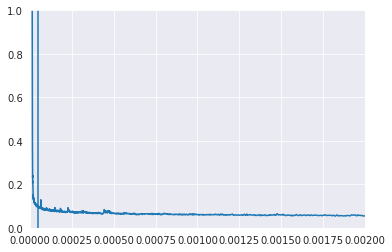

In [41]:
plt.plot(10**lrf.lrs, lrf.losses)
# plt.yscale('log')
plt.ylim(0, 1)
plt.xlim(0, 0.002)
plt.axvline(0.5e-4)